#Find the nuclei in divergent images to advance medical discovery

In this dataset we will classify microscopic images of Nucleus  from the 2018 data  Data Science Bowl [Find the nuclei in divergent images to advance medical discovery ](http://www.kaggle.com/c/data-science-bowl-2018) dataset.This dataset contains a large number of segmented nuclei images.  You'll preprocess the images, then train a U-net convolutional neural network on all the samples. The images need to be normalize and we use Data augmentation because we have small dataset. we are apply convolutional, max pooling,concatenate and upsampling At the end, you'll get to see your neural network's predictions on the sample images.
# Get the data
you can download the data hear- [Find the nuclei in divergent images to advance medical discovery ](https://www.kaggle.com/c/data-science-bowl-2018/data)



In [1]:
!pip install tqdm
!curl -LO https://raw.github.com/drj11/pypng/master/code/png.py

import numpy as np 
import pandas as pd
import sys
from urllib.request import urlretrieve
from os.path import isfile, isdir
import zipfile
import os
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize 
from keras.layers import Input
from keras.layers import Lambda
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.models import load_model
import keras.backend as K

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100   97k  100   97k    0     0    97k      0  0:00:01 --:--:--  0:00:01   97k


Using TensorFlow backend.


In [2]:
cwd = os.getcwd()

testpath = os.path.join(cwd, 'data', 'test')
trainpath = os.path.join(cwd, 'data', 'train')

if not os.path.exists(trainpath):
    os.makedirs(trainpath)

if not os.path.exists(testpath):
    os.makedirs(testpath)

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile('train.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Download Train Data') as pbar:
        urlretrieve(
            'https://storage.googleapis.com/kaggle-competitions-data/kaggle/8089/stage1_train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1526807024&Signature=AFcbuZvuzlO5F1c2h%2F38XyGhdHbOIVfkhdjehTR3gh0nOXZqjkDuCSxZKnqIVWfTJDweC3eVsuEX%2FfnDyUYvnleTP8WtL%2BMfM2YuXLkNy%2FqeUYERuCXUAbngLSqhjgD1MjEtvPDQOKbMM%2BTanIwNuCQhqDY4cFaCeQT1LDJe58c9lQQXpf3NzOcZcUlzHCjPKnF17GwF8rn%2FgGPahVUorewq6bRYJJsKzf4Wf8Sc7Ply9U88ht9m6Lv7ZVLnJPuGAlnWOXQ%2BDYA%2BHK3mNSyBd5vKATybPC%2F5TGGaTksWx7%2BdIw%2BzWSdZ2mnpIB%2BM28GQMLRcTa8S3qUDXpPVSKOZBw%3D%3D',
            'train.zip',
            pbar.hook)
        
        
if not isfile('test.zip'):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Download Test Data') as pbar:
        urlretrieve(
            'https://storage.googleapis.com/kaggle-competitions-data/kaggle/8089/stage1_test.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1526805801&Signature=kgr1P14H5lVWcP7rCDI%2F1Fg4lX1dpJYuY1RM8VRFcoG5AuTS%2Bd7MqzTCRyGv73hHAsLHdejibmgqzDp9WYKtQWi2BYZJzaMcxfSVk%2Fg16aTcvtRHbi3jgMRKH%2FSZjWlN4GncVJQHhAJTgHzyKENX04L44C%2B5vfhy2vNWGyZtd4eI%2BP0D8BvB32QDoxg%2BXhk3WaWRa46yaHLx0tfvEGe%2Fb%2FejkfpOoA9xCVb%2BQCE9I2PrMcgeatxRKLZWQ2NVCdmgkzLDv3%2B7gJKs3%2B0JdCmug5UF3vEIfHq9hcuJHpNAeX0lkm8Y3YIyrlZULDNj8%2FgFQTr63S%2BiWdbPgtAwezHUoA%3D%3D',
            'test.zip',
            pbar.hook)

with zipfile.ZipFile('train.zip') as zip_file:
    cwd = os.getcwd()
    zip_file.extractall(os.path.join(cwd, 'data', 'train'))
    zip_file.close()

with zipfile.ZipFile('test.zip') as zip_file:
    cwd = os.getcwd()
    zip_file.extractall(os.path.join(cwd, 'data', 'test'))
    zip_file.close()

print('All files Found')

All files Found


In [0]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_DEPTH = 3

TRAIN_PATH =  os.path.join('data', 'train')
TEST_PATH = os.path.join('data', 'test')

train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

In [4]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)

print('Getting And Resizing Training images and Masks...')
sys.stdout.flush()

for index, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    path = os.path.join(TRAIN_PATH, id_)
    img = imread(os.path.join(path, 'images', id_) +  '.png')[:, :, :IMG_DEPTH]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode= 'constant', preserve_range=True)
    X_train[index] = img
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
    for mask_file in next(os.walk(os.path.join(path, 'masks')))[2]:
        mask_ = imread(os.path.join(path, 'masks', mask_file))
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_HEIGHT), mode = 'constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[index] = mask

X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH), dtype = np.uint8)
    
print('Getting And Resizing Testing images and Masks...')
sys.stdout.flush()

for index, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = os.path.join(TEST_PATH, id_)
    img = imread(os.path.join(path, 'images', id_) +  '.png')[:, :, :IMG_DEPTH]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode= 'constant', preserve_range=True)
    X_test[index] = img

print('done')
print('We have {} Train images and {} Test images!'.format(X_train.shape[0],  X_test.shape[0]))

Getting And Resizing Training images and Masks...


100%|██████████| 670/670 [01:52<00:00,  5.97it/s]

Getting And Resizing Testing images and Masks...



100%|██████████| 65/65 [00:00<00:00, 68.35it/s]

done
We have 670 Train images and 65 Test images!


# Visulization Images And Masks
we have 670 Training examples, now i am generating random index and visulize images and mask, i make `display_images` method, this method has three inputs, `X_train`, `Y_train` and `id_`. the `id_` input conain indexes. i am randomly generate id_ and visulize images and mask, run below comand.

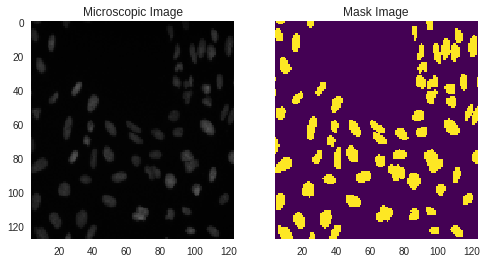

In [5]:
def display_images(id_, X_train, Y_train):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True)
    ax1.set_title('Microscopic Image')
    ax1.grid(False)
    ax1.imshow(X_train[id_])

    ax2.set_title('Mask Image')
    ax2.grid(False)
    ax2.imshow(np.squeeze(Y_train[id_]), cmap="viridis")
    plt.show()

id_ = np.random.randint(len(X_train))
display_images(id_, X_train, Y_train)

## Implement Preprocess Functions
### Normalize
In the cell below, implement the `normalize` function to take in image data, `X_train and X_test`, and return it as a normalized Numpy array. The values should be in the range of 0 to 1, inclusive.  The return object should be the same shape as `X_train and X_test`.

In [0]:
def normalize(x):
    samples = []
    for sample in x:
        samples.append(sample / 255)
    return np.array(samples)

X_train = normalize(X_train)
X_test = normalize(X_test)

# Implement Evalution and metrics
This competition is evaluated on the mean average precision at different intersection over union (IoU) thresholds. The IoU of a proposed set of object pixels and a set of true object pixels is calculated as:
![](https://uoguelph-mlrg.github.io/images/spaceNet_evaluation_metric.png)
The metric sweeps over a range of IoU thresholds, at each point calculating an average precision value. The threshold values range from 0.5 to 0.95 with a step size of 0.05: (0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95). In other words, at a threshold of 0.5, a predicted object is considered a "hit" if its intersection over union with a ground truth object is greater than 0.5.
At each threshold value t, a precision value is calculated based on the number of true positives (TP), false negatives (FN), and false positives (FP) resulting from comparing the predicted object to all ground truth objects:

\begin{align}
\frac{TP{(t)}}{TP{(t)} + FP{(t)} + FN{(t)}}
\end{align}

A true positive is counted when a single predicted object matches a ground truth object with an IoU above the threshold. A false positive indicates a predicted object had no associated ground truth object. A false negative indicates a ground truth object had no associated predicted object. The average precision of a single image is then calculated as the mean of the above precision values at each IoU threshold:

In [0]:
def iou(y_true, prediction):
    prece = []
    for e in np.arange(0.5, 1.0, 0.05):
        pred = tf.to_int32(prediction > e)
        score, opt = tf.metrics.mean_iou(y_true, pred, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([opt]):
            score = tf.identity(score)
        prece.append(score)
    return K.mean(K.stack(prece),axis=0)

# Build the network
In this project we build U-net Convolutional Networks for Image Segmentation.The u-net is convolutional network architecture for fast and precise segmentation of images. Up to now it has outperformed the prior best method (a sliding-window convolutional network) on the ISBI challenge for segmentation of neuronal structures in electron microscopic stacks. It has won the Grand Challenge for Computer-Automated Detection of Caries in Bitewing Radiography at ISBI 2015, and it has won the Cell Tracking Challenge at ISBI 2015 on the two most challenging transmitted light microscopy categories (Phase contrast and DIC microscopy) by a large margin . and we use this CNN archistructure. [Papers](https://arxiv.org/pdf/1505.04597.pdf)
![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

In [8]:
def create_model():
    
    inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH))
#     x = Lambda(lambda x : x / 255) (inputs)
    
    conv = Conv2D(16, (3, 3), padding='same', activation='relu')(inputs)
    conv = Conv2D(16, (3, 3), padding='same', activation='relu')(conv)
    p = MaxPooling2D((2, 2))(conv)
    
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(p)
    conv1 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv1)
    p1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(p1)
    conv2 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv2)
    p2 = MaxPooling2D((2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(p2)
    conv3 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv3)
    p3 = MaxPooling2D((2, 2))(conv3)
    
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu')(p3)
    conv4 = Conv2D(256, (3, 3), padding='same', activation='relu')(conv4)
    
    m = concatenate([
        Conv2D(128, (2, 2), padding='same', activation='relu')(UpSampling2D(size = (2, 2)) (conv4)),
        conv3
    ])
    
    conv5 = Conv2D(128, (3, 3), padding='same', activation='relu')(m)
    conv5 = Conv2D(128, (3, 3), padding='same', activation='relu')(conv5)
    
    m1 = concatenate([
        Conv2D(64, (2, 2), padding='same', activation='relu')(UpSampling2D(size = (2, 2)) (conv5)),
        conv2
    ])
    
    conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(m1)
    conv6 = Conv2D(64, (3, 3), padding='same', activation='relu')(conv6)
    
    m2 = concatenate([
        Conv2D(32, (2, 2), padding='same', activation='relu')(UpSampling2D(size = (2, 2)) (conv6)),
        conv1
    ])
    
    conv7 = Conv2D(32, (3, 3), padding='same', activation='relu')(m2)
    conv7 = Conv2D(32, (3, 3), padding='same', activation='relu')(conv7)
    
    m3 = concatenate([
        Conv2D(16, (2, 2), padding='same', activation='relu')(UpSampling2D(size = (2, 2)) (conv7)),
        conv
    ])
    
    conv8 = Conv2D(16, (3, 3), padding='same', activation='relu')(m3)
    conv8 = Conv2D(16, (3, 3), padding='same', activation='relu')(conv8)
    
    output = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(conv8)
    
    model = Model(inputs = inputs, outputs = output)
    model.compile(loss = 'binary_crossentropy', optimizer = 'Adam', metrics = [iou])
    return model
    
model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

# Train the model
now we train our model, before we train the model we set our callbacks
*   **ModelCheckpoint** :  For example: if filepath  is **model-capstone_project_udacity_by_jimit_jaishwal**, then the model checkpoints will be saved with the epoch number and the validation loss in the filename.
*  **EarlyStopping** : Stop training when a monitored quantity has stopped improving.

In [9]:
FILE_PATH = 'model-capstone_project_udacity_by_jimit_jaishwal'
checkpointer = ModelCheckpoint(FILE_PATH, verbose=1, save_best_only=True)
stoper = EarlyStopping(verbose=1, patience=5)

BATCH = 4
EPOCH = 45

model.fit(epochs= EPOCH,
          x = X_train,
          y = Y_train, shuffle = False,
          batch_size = BATCH,
          validation_split = 0.1,
          callbacks=[checkpointer, stoper])

Train on 603 samples, validate on 67 samples
Epoch 1/45
603/603 [==============================] - 16s 27ms/step - loss: 0.3564 - iou: 0.4185 - val_loss: 0.1652 - val_iou: 0.4268

Epoch 00001: val_loss improved from inf to 0.16519, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 2/45
603/603 [==============================] - 13s 21ms/step - loss: 0.1870 - iou: 0.4703 - val_loss: 0.1244 - val_iou: 0.5169

Epoch 00002: val_loss improved from 0.16519 to 0.12440, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 3/45
124/603 [=====>........................] - ETA: 9s - loss: 0.1252 - iou: 0.5299

603/603 [==============================] - 13s 21ms/step - loss: 0.1179 - iou: 0.5643 - val_loss: 0.0900 - val_iou: 0.6040

Epoch 00003: val_loss improved from 0.12440 to 0.09001, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 4/45
603/603 [==============================] - 12s 21ms/step - loss: 0.1002 - iou: 0.6328 - val_loss: 0.0870 - val_iou: 0.6566

Epoch 00004: val_loss improved from 0.09001 to 0.08701, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 5/45
260/603 [===========>..................] - ETA: 6s - loss: 0.0922 - iou: 0.6654

603/603 [==============================] - 12s 21ms/step - loss: 0.0932 - iou: 0.6746 - val_loss: 0.0876 - val_iou: 0.6898

Epoch 00005: val_loss did not improve from 0.08701
Epoch 6/45
603/603 [==============================] - 12s 20ms/step - loss: 0.0940 - iou: 0.7015 - val_loss: 0.0737 - val_iou: 0.7127

Epoch 00006: val_loss improved from 0.08701 to 0.07369, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 7/45
400/603 [==================>...........] - ETA: 4s - loss: 0.0842 - iou: 0.7196

603/603 [==============================] - 13s 21ms/step - loss: 0.0881 - iou: 0.7223 - val_loss: 0.0735 - val_iou: 0.7305

Epoch 00007: val_loss improved from 0.07369 to 0.07346, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 8/45
603/603 [==============================] - 13s 21ms/step - loss: 0.0836 - iou: 0.7380 - val_loss: 0.0692 - val_iou: 0.7446

Epoch 00008: val_loss improved from 0.07346 to 0.06916, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 9/45
300/603 [=============>................] - ETA: 5s - loss: 0.0765 - iou: 0.7480

603/603 [==============================] - 13s 21ms/step - loss: 0.0801 - iou: 0.7507 - val_loss: 0.0670 - val_iou: 0.7562

Epoch 00009: val_loss improved from 0.06916 to 0.06702, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 10/45
603/603 [==============================] - 13s 21ms/step - loss: 0.0784 - iou: 0.7613 - val_loss: 0.0656 - val_iou: 0.7658

Epoch 00010: val_loss improved from 0.06702 to 0.06563, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 11/45
284/603 [=============>................] - ETA: 6s - loss: 0.0712 - iou: 0.7680

603/603 [==============================] - 12s 21ms/step - loss: 0.0771 - iou: 0.7701 - val_loss: 0.0639 - val_iou: 0.7739

Epoch 00011: val_loss improved from 0.06563 to 0.06389, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 12/45
603/603 [==============================] - 12s 21ms/step - loss: 0.0776 - iou: 0.7774 - val_loss: 0.0634 - val_iou: 0.7806

Epoch 00012: val_loss improved from 0.06389 to 0.06344, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 13/45
280/603 [============>.................] - ETA: 6s - loss: 0.0689 - iou: 0.7822

603/603 [==============================] - 13s 21ms/step - loss: 0.0755 - iou: 0.7838 - val_loss: 0.0623 - val_iou: 0.7866

Epoch 00013: val_loss improved from 0.06344 to 0.06228, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 14/45
603/603 [==============================] - 12s 21ms/step - loss: 0.0744 - iou: 0.7894 - val_loss: 0.0620 - val_iou: 0.7918

Epoch 00014: val_loss improved from 0.06228 to 0.06200, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 15/45
280/603 [============>.................] - ETA: 6s - loss: 0.0670 - iou: 0.7931

603/603 [==============================] - 13s 21ms/step - loss: 0.0732 - iou: 0.7943 - val_loss: 0.0611 - val_iou: 0.7965

Epoch 00015: val_loss improved from 0.06200 to 0.06108, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 16/45
603/603 [==============================] - 12s 21ms/step - loss: 0.0720 - iou: 0.7987 - val_loss: 0.0598 - val_iou: 0.8007

Epoch 00016: val_loss improved from 0.06108 to 0.05976, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 17/45
280/603 [============>.................] - ETA: 6s - loss: 0.0682 - iou: 0.8017

603/603 [==============================] - 13s 21ms/step - loss: 0.0727 - iou: 0.8027 - val_loss: 0.0594 - val_iou: 0.8045

Epoch 00017: val_loss improved from 0.05976 to 0.05935, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 18/45
603/603 [==============================] - 13s 21ms/step - loss: 0.0711 - iou: 0.8063 - val_loss: 0.0598 - val_iou: 0.8079

Epoch 00018: val_loss did not improve from 0.05935
Epoch 19/45
324/603 [===============>..............] - ETA: 5s - loss: 0.0676 - iou: 0.8089

603/603 [==============================] - 13s 21ms/step - loss: 0.0709 - iou: 0.8096 - val_loss: 0.0588 - val_iou: 0.8110

Epoch 00019: val_loss improved from 0.05935 to 0.05877, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 20/45
603/603 [==============================] - 13s 21ms/step - loss: 0.0714 - iou: 0.8125 - val_loss: 0.0591 - val_iou: 0.8138

Epoch 00020: val_loss did not improve from 0.05877
Epoch 21/45
328/603 [===============>..............] - ETA: 5s - loss: 0.0676 - iou: 0.8147

603/603 [==============================] - 13s 21ms/step - loss: 0.0700 - iou: 0.8152 - val_loss: 0.0596 - val_iou: 0.8164

Epoch 00021: val_loss did not improve from 0.05877
Epoch 22/45
603/603 [==============================] - 13s 21ms/step - loss: 0.0708 - iou: 0.8177 - val_loss: 0.0575 - val_iou: 0.8188

Epoch 00022: val_loss improved from 0.05877 to 0.05754, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 23/45
408/603 [===================>..........] - ETA: 3s - loss: 0.0670 - iou: 0.8197

603/603 [==============================] - 12s 21ms/step - loss: 0.0681 - iou: 0.8200 - val_loss: 0.0571 - val_iou: 0.8211

Epoch 00023: val_loss improved from 0.05754 to 0.05714, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 24/45
603/603 [==============================] - 13s 21ms/step - loss: 0.0674 - iou: 0.8223 - val_loss: 0.0570 - val_iou: 0.8233

Epoch 00024: val_loss improved from 0.05714 to 0.05699, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 25/45
296/603 [=============>................] - ETA: 6s - loss: 0.0632 - iou: 0.8239

603/603 [==============================] - 13s 21ms/step - loss: 0.0668 - iou: 0.8244 - val_loss: 0.0566 - val_iou: 0.8253

Epoch 00025: val_loss improved from 0.05699 to 0.05662, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 26/45
603/603 [==============================] - 13s 21ms/step - loss: 0.0663 - iou: 0.8263 - val_loss: 0.0573 - val_iou: 0.8272

Epoch 00026: val_loss did not improve from 0.05662
Epoch 27/45
324/603 [===============>..............] - ETA: 5s - loss: 0.0634 - iou: 0.8278

603/603 [==============================] - 12s 21ms/step - loss: 0.0664 - iou: 0.8281 - val_loss: 0.0567 - val_iou: 0.8290

Epoch 00027: val_loss did not improve from 0.05662
Epoch 28/45
603/603 [==============================] - 12s 21ms/step - loss: 0.0669 - iou: 0.8299 - val_loss: 0.0574 - val_iou: 0.8306

Epoch 00028: val_loss did not improve from 0.05662
Epoch 29/45
476/603 [======================>.......] - ETA: 2s - loss: 0.0698 - iou: 0.8312

603/603 [==============================] - 12s 20ms/step - loss: 0.0685 - iou: 0.8313 - val_loss: 0.0562 - val_iou: 0.8320

Epoch 00029: val_loss improved from 0.05662 to 0.05616, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 30/45
603/603 [==============================] - 12s 21ms/step - loss: 0.0667 - iou: 0.8328 - val_loss: 0.0562 - val_iou: 0.8335

Epoch 00030: val_loss did not improve from 0.05616
Epoch 31/45
352/603 [================>.............] - ETA: 4s - loss: 0.0626 - iou: 0.8339

603/603 [==============================] - 13s 21ms/step - loss: 0.0669 - iou: 0.8342 - val_loss: 0.0569 - val_iou: 0.8348

Epoch 00031: val_loss did not improve from 0.05616
Epoch 32/45
603/603 [==============================] - 12s 21ms/step - loss: 0.0672 - iou: 0.8355 - val_loss: 0.0559 - val_iou: 0.8360

Epoch 00032: val_loss improved from 0.05616 to 0.05594, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 33/45
412/603 [===================>..........] - ETA: 3s - loss: 0.0628 - iou: 0.8365

603/603 [==============================] - 12s 20ms/step - loss: 0.0638 - iou: 0.8367 - val_loss: 0.0558 - val_iou: 0.8373

Epoch 00033: val_loss improved from 0.05594 to 0.05583, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 34/45
603/603 [==============================] - 12s 21ms/step - loss: 0.0632 - iou: 0.8380 - val_loss: 0.0560 - val_iou: 0.8386

Epoch 00034: val_loss did not improve from 0.05583
Epoch 35/45
344/603 [================>.............] - ETA: 5s - loss: 0.0621 - iou: 0.8390

603/603 [==============================] - 13s 21ms/step - loss: 0.0637 - iou: 0.8392 - val_loss: 0.0572 - val_iou: 0.8398

Epoch 00035: val_loss did not improve from 0.05583
Epoch 36/45
603/603 [==============================] - 13s 21ms/step - loss: 0.0650 - iou: 0.8403 - val_loss: 0.0579 - val_iou: 0.8408

Epoch 00036: val_loss did not improve from 0.05583
Epoch 37/45
480/603 [======================>.......] - ETA: 2s - loss: 0.0690 - iou: 0.8412

603/603 [==============================] - 12s 20ms/step - loss: 0.0687 - iou: 0.8413 - val_loss: 0.0575 - val_iou: 0.8416

Epoch 00037: val_loss did not improve from 0.05583
Epoch 38/45
603/603 [==============================] - 12s 20ms/step - loss: 0.0661 - iou: 0.8421 - val_loss: 0.0552 - val_iou: 0.8425

Epoch 00038: val_loss improved from 0.05583 to 0.05521, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 39/45
432/603 [====================>.........] - ETA: 3s - loss: 0.0616 - iou: 0.8429

603/603 [==============================] - 12s 21ms/step - loss: 0.0632 - iou: 0.8431 - val_loss: 0.0548 - val_iou: 0.8435

Epoch 00039: val_loss improved from 0.05521 to 0.05475, saving model to model-capstone_project_udacity_by_jimit_jaishwal
Epoch 40/45
603/603 [==============================] - 12s 21ms/step - loss: 0.0618 - iou: 0.8440 - val_loss: 0.0549 - val_iou: 0.8445

Epoch 00040: val_loss did not improve from 0.05475
Epoch 41/45
344/603 [================>.............] - ETA: 5s - loss: 0.0592 - iou: 0.8448

603/603 [==============================] - 12s 20ms/step - loss: 0.0617 - iou: 0.8450 - val_loss: 0.0566 - val_iou: 0.8454

Epoch 00041: val_loss did not improve from 0.05475
Epoch 42/45
603/603 [==============================] - 12s 20ms/step - loss: 0.0688 - iou: 0.8458 - val_loss: 0.0595 - val_iou: 0.8461

Epoch 00042: val_loss did not improve from 0.05475
Epoch 43/45
480/603 [======================>.......] - ETA: 2s - loss: 0.0675 - iou: 0.8464

603/603 [==============================] - 12s 20ms/step - loss: 0.0666 - iou: 0.8464 - val_loss: 0.0558 - val_iou: 0.8468

Epoch 00043: val_loss did not improve from 0.05475
Epoch 44/45
603/603 [==============================] - 12s 20ms/step - loss: 0.0625 - iou: 0.8472 - val_loss: 0.0551 - val_iou: 0.8475

Epoch 00044: val_loss did not improve from 0.05475
Epoch 00044: early stopping


#  Prediction
Now we are predicting a validation train and test dataset and  check how accurate our CNN model?

In [0]:
model = load_model(filepath=FILE_PATH, custom_objects={'iou' : iou})

predict_train_set = model.predict(X_train[:int(X_train.shape[0] * 0.9)])
predict_val_set = model.predict(X_train[int(X_train.shape[0] * 0.9):])
predict_test_set = model.predict(X_test)

def set_threshold(preds):
    return (preds > 0.5).astype(np.uint8)

predict_train_set = set_threshold(predict_train_set)
predict_val_set = set_threshold(predict_val_set)
predict_test_set = set_threshold(predict_test_set)

# Visualize Prediction

now we test and visualize our predicting results and check how well model perform 

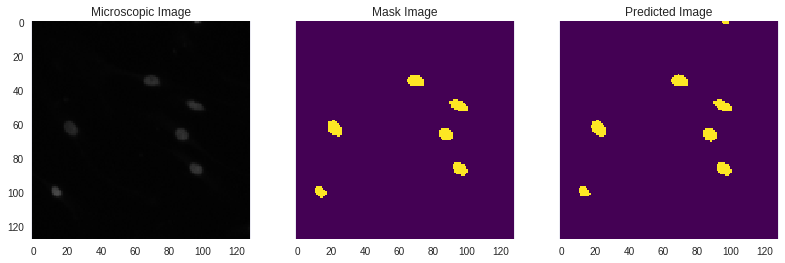

In [11]:
def display_results(id_, X_train, Y_train, predicted):
    fig, arr = plt.subplots(1, 3, figsize=(13.4, 4), sharey=True,sharex=True)
    arr[0].set_title('Microscopic Image')
    arr[0].grid(False)
    arr[0].imshow(X_train[id_])

    arr[1].set_title('Mask Image')
    arr[1].grid(False)
    arr[1].imshow(np.squeeze(Y_train[id_]), cmap="viridis")
    
    arr[2].imshow(np.squeeze(predicted[id_]), cmap="viridis")
    arr[2].set_title('Predicted Image')
    arr[2].grid(False)
        
id_ = np.random.randint(0, len(predict_train_set))
display_results(id_, X_train, Y_train, predict_train_set)

# Save Results in local disks
now we save all predicted test images in local disks.

In [12]:
import png 
resultspath = os.path.join(cwd, 'results')

if not os.path.exists(resultspath):
    os.makedirs(resultspath)

for index, image in enumerate(predict_test_set):
    image_id = test_ids[index] + '.png'
    png.from_array(image, 'L').save(os.path.join(resultspath, image_id))  

print('All images saved successfully!')

All images saved successfully!
